# Classification
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.cross_validation

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## A Motivating Example Using `sklearn`: Heights and Weights

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


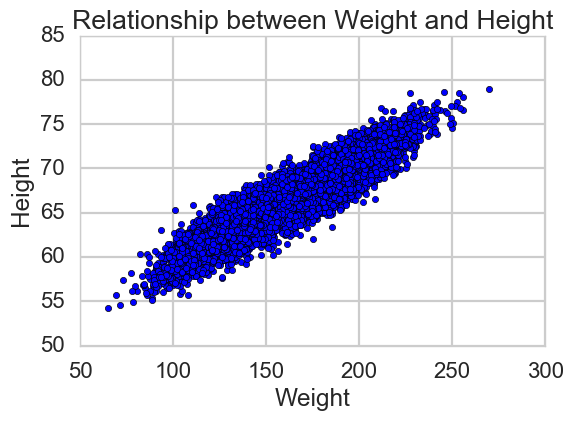

In [3]:
# Checkup Exercise Set I:
#    Create a scatter plot of Weight vs. Height
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(dflog.Weight, dflog.Height)
plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Relationship between Weight and Height")


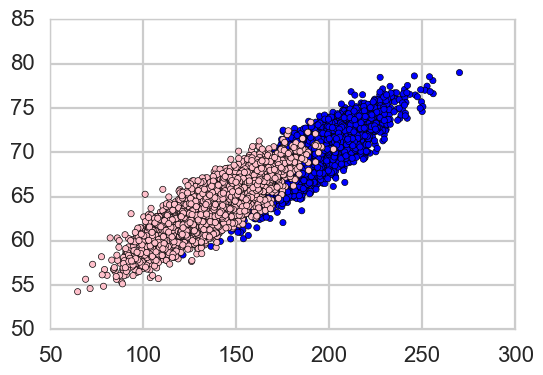

In [4]:
# Checkup Exercise Set I:
#    Color the points differently by Gender.
plt.scatter(dflog.Weight, dflog.Height, c=['Blue' if gender == 'Male' else 'Pink' for gender in dflog['Gender']])


First, we try a basic Logistic Regression:

* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)

clf = LogisticRegression()

# Fit the model on the training data.
clf.fit(Xlr, ylr)

# Print the accuracy score of the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9252


### Tuning the Model

We use the following `cv_score` function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [6]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization.

In [7]:
# First, we try a basic Logistic Regression:
# Split the data into a training and test set
# Train on the training set, and test for accuracy on the testing set
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender=="Male").values,random_state=5)
clf = LogisticRegression()
clf.fit(Xlr,ylr)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# your turn
# Checkup Exercise Set II
# Find the best model parameters based only on training set.
# For each C: 
#   1) Create a logistic regression model with that value of C 
#   2) Find the average score for this model using the cv_score 
#       function only on the training set (Xlr, ylr) 
#   3) Pick the C with the highest average score 
results = []
max_score = 0
for c in Cs:
    clf = LogisticRegression(C=c)
    clf.fit(Xlr, ylr)
    score = accuracy_score(clf.predict(Xlr),ylr)
    print("For c value of %f score is: %f" % (c, score))
    if (score > max_score):
        max_score = score
        best_c = c

print("Best c value is: %f with a score of: %f" % (best_c, max_score))

For c value of 0.001000 score is: 0.916933
For c value of 0.100000 score is: 0.916800
For c value of 1.000000 score is: 0.916800
For c value of 10.000000 score is: 0.916800
For c value of 100.000000 score is: 0.916800
Best c value is: 0.001000 with a score of: 0.916933


In [9]:
# your turn
# Checkup Exercise Set III
# 1) Use the C obtained from procedure above and train
#    a Logistic Regression on the training data.
clf = LogisticRegression(C=best_c)
clf.fit(Xlr, ylr)

# 2) Calculate the accurace on the test data.
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
print(accuracy)

0.9256


### Black Box Grid Search in `sklearn`

In [27]:
# your turn
# Checkup Exercise Set IV
# 1) Use GridSearchCV to find the best model over the training set
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score='raise')[source]¶
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(C=1), param_grid=param_grid)
clf.fit(Xlr, ylr)

print("Grid scores:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
    
print("Accuracy is: %f" % accuracy_score(clf.predict(Xtestlr), ytestlr))
print()

print("Classification report:")
print()

print("The best model of training set based on GridSearchCV:")
print()
y_true, y_pred = ytestlr, clf.predict(Xtestlr)
print(classification_report(y_true, y_pred))


Grid scores:
0.916 (+/-0.002) for {'C': 0.001}
0.917 (+/-0.002) for {'C': 0.1}
0.917 (+/-0.002) for {'C': 1}
0.917 (+/-0.002) for {'C': 10}
0.917 (+/-0.002) for {'C': 100}
Accuracy is: 0.925200

Classification report:

The best model of training set based on GridSearchCV:

             precision    recall  f1-score   support

      False       0.92      0.93      0.92      1232
       True       0.93      0.92      0.93      1268

avg / total       0.93      0.93      0.93      2500



## A Walkthrough of the Math Behind Logistic Regression

In [18]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.grid_search.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [19]:
from sklearn.cross_validation import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

## Logistic Regression: The Math

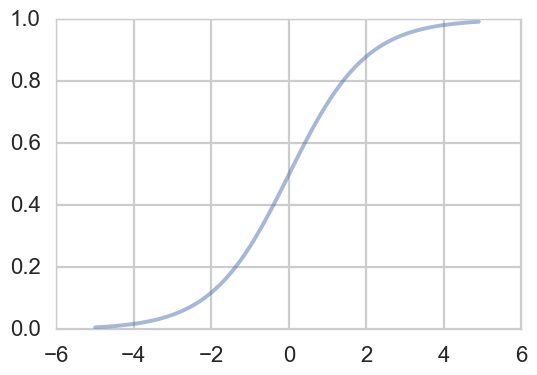

In [20]:
h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [14]:
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [28]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


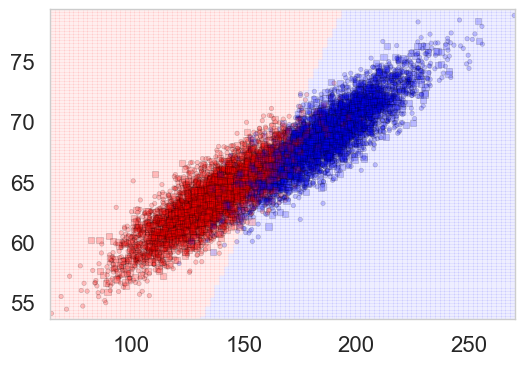

In [22]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

In [23]:
clf_l.predict_proba(Xtest_l)

array([[ 0.05426815,  0.94573185],
       [ 0.12727578,  0.87272422],
       [ 0.07551666,  0.92448334],
       ..., 
       [ 0.96633645,  0.03366355],
       [ 0.00324165,  0.99675835],
       [ 0.98605732,  0.01394268]])

### Discriminative vs Generative Classifier

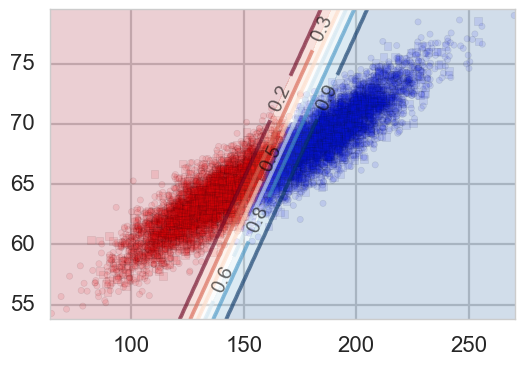

In [24]:
plt.figure()
ax = plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);